In [ ]:
''' Perform an EDA on supermarket customer data then build an object oriented Markov Chain approach to simulate the shopping behaviour of customers.'''

In [41]:
import pandas as pd
import seaborn as sns

# EDA

In [42]:
data = pd.read_csv("./data/monday.csv", delimiter=";", index_col='timestamp', parse_dates=True)
data.head(25)

,customer_no,location
timestamp,,
2019-09-02 07:03:00,1,dairy
2019-09-02 07:03:00,2,dairy
2019-09-02 07:04:00,3,dairy
2019-09-02 07:04:00,4,dairy
2019-09-02 07:04:00,5,spices
2019-09-02 07:04:00,6,spices
2019-09-02 07:04:00,7,spices
2019-09-02 07:04:00,8,fruit
2019-09-02 07:05:00,1,checkout


<AxesSubplot:xlabel='location'>

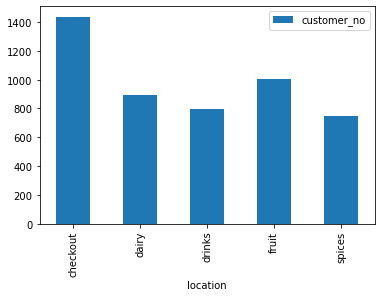

In [43]:
# plot total amount each location is visited
data.groupby(['location']).apply('count').plot(kind='bar')

In [44]:
# statistics of locations visited
data.groupby(['customer_no']).apply('count').describe()

,location
count,1447.000000
mean,3.375259
std,1.830893
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,18.000000


<AxesSubplot:xlabel='location'>

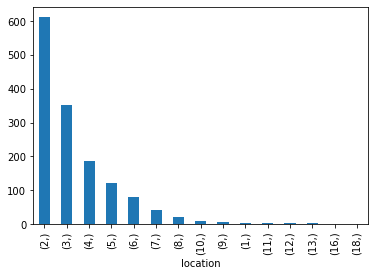

In [45]:
# plot frequency distirbution of locations visited
data.groupby(['customer_no']).apply('count').value_counts().plot.bar()

In [46]:
# add frequency column to each customer to filter on later
data['index_col'] = data.index
freq = data.groupby(['customer_no']).apply('count')
data = data.merge(freq, on='customer_no')
data.set_index(keys='index_col_x', drop=True, inplace=True)
data.index.names = ['date'] #rename index

In [47]:
data.rename(columns={'location_x':'location', 'location_y':'customer_locations'}, inplace=True)
data.drop('index_col_y', inplace=True, axis=1)

<AxesSubplot:xlabel='date', ylabel='customer_locations'>

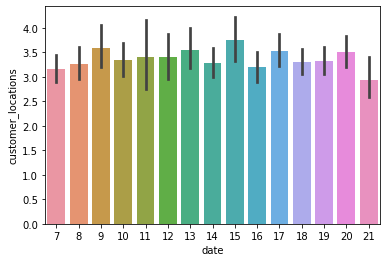

In [48]:
# plot frequency of locations vs. hour of day
data_checkout = data[data['location'] == 'checkout']
sns.barplot(data=data_checkout, x=data_checkout.index.hour, y='customer_locations')

In [49]:
# remove frequency again, done with plotting
data.drop('customer_locations', inplace=True, axis=1)

# Markov Chain

In [50]:
# filter out customers who never go through checkout
filter = data[data['location']=='checkout']['customer_no']
data = data[data['customer_no'].isin(filter)]

In [51]:
# add entrance category to data
entrance_shift = data.groupby('customer_no')['location'].shift(1).fillna('entrance').to_frame()
entrance_shift = pd.concat([entrance_shift, data['customer_no']], axis=1)
entrance_shift = entrance_shift[entrance_shift['location']=='entrance']
entrance_shift.index = entrance_shift.index - pd.Timedelta(minutes=1) # entrance occurs 1 min. before first real location
data = pd.concat([entrance_shift,data]).sort_values(by='date') # add entrance

In [52]:
# create column indicating next location of customer
data['next_location'] = data.groupby('customer_no')['location'].shift(-1)
data['next_location'] = data['next_location'].fillna('entrance') # this is a "trick" to get the entrance
# columns in the crosstab "next_location" column. its not "logically" correct. 

In [53]:
def calculate_transition_prob_matrix(data, window):
    """ Calculates transition probablity between different locations. Can set a window for specific hours of the visit."""
    if window != 0:
        # extract the windowed data frame
        hour = data.index.hour
        data_window = data.iloc[(hour == window)]
        data = data_window

    # calculate probability to transition from one location to another
    transition_probability_matrix = pd.crosstab(data['next_location'], data['location'], normalize=1)
    # fix proper transition values at boundaties
    transition_probability_matrix["checkout"]["entrance"] = 0.0
    transition_probability_matrix["checkout"]["checkout"] = 1.0

    return transition_probability_matrix

In [54]:
# build multi dimensional transition matrix for each hour
transition_probability_matrix_hourly = []
for hour in range(7,22):
    tmp = calculate_transition_prob_matrix(data, hour)
    transition_probability_matrix_hourly.append(tmp)

In [55]:
transition_probability_matrix_hourly[0]

location,checkout,dairy,drinks,entrance,fruit,spices
next_location,,,,,,
checkout,1.0,0.491525,0.516667,0.000000,0.481481,0.230769
dairy,0.0,0.000000,0.066667,0.245098,0.314815,0.250000
drinks,0.0,0.169492,0.000000,0.225490,0.148148,0.384615
entrance,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
fruit,0.0,0.152542,0.183333,0.264706,0.000000,0.134615
spices,0.0,0.186441,0.233333,0.264706,0.055556,0.000000


In [56]:
# add more date features as columns to a seconds dataframe, used later for sampling customers
def extract_date_features(data):
    """ Copy data and add date information as feature columns """
    data_time_features = data.copy()
    data_time_features['weekday'] = data_time_features.index.dayofweek
    data_time_features['hour'] = data_time_features.index.hour
    data_time_features['minute'] = data_time_features.index.minute
    return data_time_features

def get_entrance_date_weights(data_time_features):
    """ Extract hours and minutes for customer entrances and returns an array of the pairs, which can be used
    inside a random.choise to sample random dates like a PDF."""
    date_weights = data_time_features[data_time_features['location']=='entrance'].loc[:, ['hour', 'minute']].to_numpy()
    return date_weights

In [57]:
data_time_features = extract_date_features(data)
date_weights = get_entrance_date_weights(data_time_features)

# OOP Approach

In [65]:
import random
import numpy as np 
import csv 
import datetime

class Customer():
    """ Describe customer behaviour inside supermarket using MCMC """
    def __init__(self, state, transition_probability_matrix_hourly, date_weights, customer_no, budget=100, name='idc'):
        self.name = name
        self.state = state
        self.state_weights = state
        self.size = len(self.state) #  matrix is (size)x(size)
        self.budget = budget
        self.date_weights = date_weights
        self.step_counter = 0 # counts how many locations customer visits
        self.time = self.get_entrance_time()
        self.current_date = self.init_date()
        self.customer_no = customer_no
        # choose the proper transition matrix:
        hour = self.time[0]
        idx = hour - 7 # supermarket opens at 7, convert time to index of probability matrix list
        self.transition_probability_matrix = transition_probability_matrix_hourly[idx]


    def init_date(self):
        entry_date = datetime.datetime.now() # day,month,year for now only placeholder. we only care about min and hour
        entry_date = entry_date.replace(hour=self.time[0], minute=self.time[1], second=0, microsecond=0)
        return entry_date

    def get_entrance_time(self):
        """ Samples a random date from the input weights """
        time = random.choice(self.date_weights)

        return time

    def apply_transition(self):
        """ Calculate weights after 1 step. """
        self.state_weights = self.transition_probability_matrix.dot(self.state) # set transition probs by matrix multiplication
        
        return None

    def next_state(self):
        """ propagate a single customer through the supermarket using MCMC """
        idx_list = [_ for _ in range(self.size)] # list of possible indexes
        next_idx = random.choices(idx_list, weights = self.state_weights, k = 1) # index of next location
        zero_array = np.zeros(self.size)
        zero_array[next_idx] = 1.0 # set array-element of next location to 1.0
        self.state = zero_array
        self.step_counter += 1

        return self.state

    def is_active(self):
        """ Return True if customer has not reach the checkout yet. """
        zero_array = np.zeros(self.size)
        zero_array[0] = 1.0 # set location to checkout
        checkout_state = zero_array

        return (self.state != checkout_state).any()

    def convert_state_to_string(self):
        """ Convert the numerical state array into a string stating the location. """
        state_names = transition_probability_matrix.columns
        idx_location = np.where(self.state == 1) # index of current location
        location_string = transition_probability_matrix.columns[idx_location[0]][0]

        return location_string

    def add_timestep_to_date(self):
        """ Build the dates to be written into the .csv file for this customer. """
        self.current_date += datetime.timedelta(minutes=1) # assume each customer is 1 min in each location

        return None

    def print_customers(self):
        """ Print the date and customer locations into a .csv file """
        header = ['timestamp', 'customer_no', 'location']
        with open("./output/result.csv", 'a', newline='') as f:
            writer = csv.writer(f, delimiter=';')
            if f.tell() == 0:
                writer.writerow(header)
            writer.writerow([self.current_date, self.customer_no, self.convert_state_to_string()])

        return None

    def __repr__(self):
        return f"Customer {self.name} in {self.state}"


In [59]:
# class Supermarket():
#     """ Randomly populate and simulate the behaviour of mutliple customers inside the supermarket. """
#     def __init__(self, date_weights):        
#         # a list of Customer objects
#         self.customers = []
#         self.minutes = 0
#         self.last_id = 0
#         self.date_weights = date_weights

#     def add_customer(self, customer):
#         """ Add customer to supermarket """
#         self.customers.append(customer)
        
#         return None

#     def get_entrance_time(self):
#         """ Samples a random date from the input weights """
#         return random.choice(self.date_weights)


#     def __repr__(self):
#         return ''


#     def print_customers(self):
#         """print all customers with the current time and id in CSV format.
#         """
#         return None

#     def next_minute(self):
#         """propagates all customers to the next state.
#         """
#         return None
    

#     def remove_exitsting_customers(self):
#         """removes every customer that is not active any more.
#         """
#         return None


In [69]:
# simulate N customers
N = 2000
customer_no = 0
initial_state = np.array([0,0,0,1,0,0])

while customer_no < N:
    cust = Customer(initial_state, transition_probability_matrix_hourly, date_weights, customer_no)

    while cust.is_active():
        cust.print_customers() # print entry row
        cust.apply_transition()
        next_state = cust.next_state()
        cust.add_timestep_to_date()
        print(f"Customer {customer_no} is in {cust.convert_state_to_string()}.")
        
    cust.print_customers()
    customer_no += 1



Customer 0 is in drinks.
Customer 0 is in checkout.
Customer 1 is in fruit.
Customer 1 is in checkout.
Customer 2 is in dairy.
Customer 2 is in checkout.
Customer 3 is in spices.
Customer 3 is in dairy.
Customer 3 is in fruit.
Customer 3 is in dairy.
Customer 3 is in drinks.
Customer 3 is in checkout.
Customer 4 is in drinks.
Customer 4 is in checkout.
Customer 5 is in fruit.
Customer 5 is in checkout.
Customer 6 is in dairy.
Customer 6 is in drinks.
Customer 6 is in spices.
Customer 6 is in dairy.
Customer 6 is in drinks.
Customer 6 is in spices.
Customer 6 is in checkout.
Customer 7 is in dairy.
Customer 7 is in checkout.
Customer 8 is in fruit.
Customer 8 is in drinks.
Customer 8 is in spices.
Customer 8 is in dairy.
Customer 8 is in drinks.
Customer 8 is in fruit.
Customer 8 is in checkout.
Customer 9 is in fruit.
Customer 9 is in drinks.
Customer 9 is in checkout.
Customer 10 is in fruit.
Customer 10 is in dairy.
Customer 10 is in drinks.
Customer 10 is in checkout.
Customer 11 is